In [ ]:
# If I want to upload an image from local machine, run this cell:
from google.colab import files
uploaded = files.upload()


Saving flower1.jpg to flower1 (1).jpg


In [ ]:
# Import required Libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# Open an image file
img = Image.open("flower1.jpg")
img = img.convert('RGB') #This ensures the image is in RGB Format

In [ ]:
# Convert the image into a Numpy Array
img_np = np.array(img)

Let's break down what the code is doing step by step:

Extracting the Color Channels:

img_np[...,:3] selects the first three channels of the image array. For a typical RGB image, these channels are Red, Green, and Blue. The ellipsis (...) means "for every row and column," so you're applying the operation to every pixel in the image. Applying the Grayscale Formula with a Dot Product:

The grayscale conversion formula is: Gray = 0.299 × R + 0.587 × G + 0.114 × B

np.dot(img_np[...,:3], [0.299, 0.587, 0.114]) computes this formula for every pixel. Essentially, for each pixel, it multiplies the red value by 0.299, the green value by 0.587, and the blue value by 0.114, and then sums these products to produce a single intensity value that represents the brightness (luminance) of that pixel.

In [ ]:
gray_np = np.dot(img_np[...,:3], [0.299, 0.587, 0.114])
gray_np = gray_np.astype(np.float64)

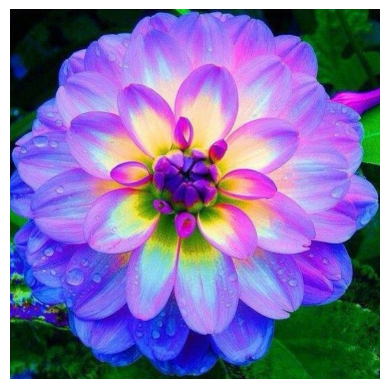

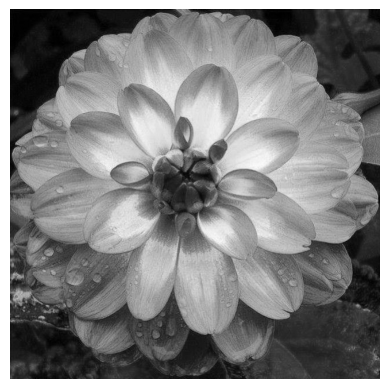

In [ ]:
# Display the grayscale image using matplotlib
plt.imshow(img, cmap="viridis")
plt.axis("off")
plt.show()

plt.imshow(gray_np, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
# step 1: Define a custom 2D convolution function
def my_convolve2d(image, kernel):
  """
  perform a 2D convolution between an image and a kernel.
  This function implements "same" convolution with symmetric padding

  parameters:
  image: 2D numpy array representing the gray scale image.
  kernel: 2D numpy representing the filter kernel

  Returns:
  output: 2D numpy array of the convolved image(same size as the input image).
  """
  # Flip the kernel: convolution requires the kernel to be fliped
  kernel = np.flipud(np.fliplr(kernel))

  iH, iW = image.shape
  kH, kW = kernel.shape

  # Calculate padding dimensions (Assumes kernel dimenstions are odd).
  pad_h = kH //2
  pad_w = kW //2

  # Pad the image using symmetric padding.
  padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='symmetric')

  # Initialize the output array.
  output = np.zeros((iH, iW), dtype=np.float64)

  #perform the convolution operation
  for i in range(iH):
    for j in range(iW):
      region = padded_image[i:i+kH, j:j+kW]
      output[i, j] = np.sum(region * kernel)

  return output


In [ ]:
# Define the sobel operator as function
def sobel_operator(image):
  """
  Apply the sobel operator to a grayscale image to detect edges.

  parameters:
  image: 2D numpy array representing the gray scale image.

  Returns:
  gradient_magnitude: 2D numpy array of the computed edge magnitudes.
  grad_x: 2D numpy array of the x-direction gradient values.
  grad_y: 2D numpy array of the y-direction gradient values.
  """
  #Define the sobel kernels.
  sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
  sobel_y = np.array([[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]])

  #Compute the gradients in X and Y directions using the custom convolution function.
  grad_x = my_convolve2d(image, sobel_x)
  grad_y = my_convolve2d(image, sobel_y)

  # Computer the gradient magnitude(edge strength) at each pixel.
  gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

  return gradient_magnitude, grad_x, grad_y

In [ ]:
# Apply the sobel operator to the grayscale image.
edges, grad_x, grad_y = sobel_operator(gray_np)

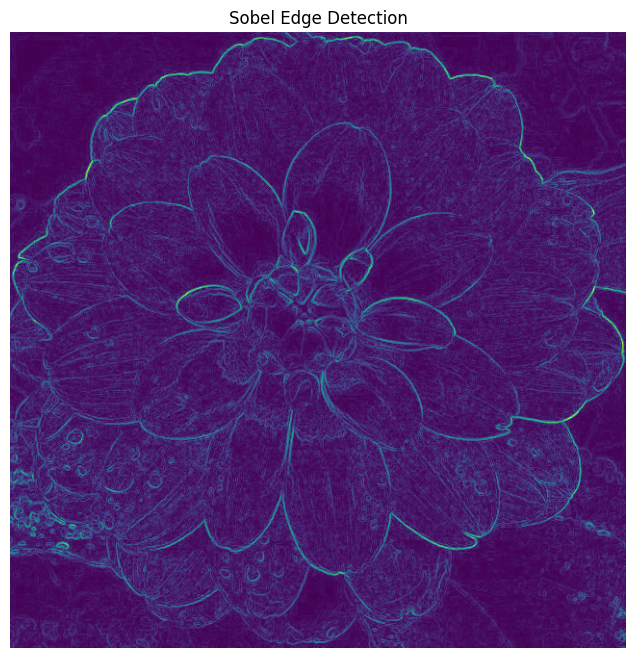

In [ ]:
# Visualize the edge-detected image.
plt.figure(figsize=(12, 8))
plt.imshow(edges, cmap='viridis')
plt.title('Sobel Edge Detection')
plt.axis('off')
plt.show()

In [ ]:
#step 3: Define a function to create a Gaussian Kernel manually:
def gaussian_kernel(kernel_size, sigma):
  """
  Generate a 2D Gaussian kernel.
   Parameters:
   kernel_size: An odd integer representing the width and the height of the kernel.
   sigma: the standard deviation of the Gaussian distribution.

   Returns:
   A 2D numpy array representing the normalized Gaussian Kernel.
   """
  # Create a coordinate grid centered at 0.
  ax = np.linspace(-(kernel_size - 1) / 2, (kernel_size - 1) / 2, kernel_size)
  xx, yy = np.meshgrid(ax, ax)

  # Calculate the Gaussian function for each (x, y) pair.
  kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))

  # Normalize the kernel so that the sum is 1.
  kernel = kernel / np.sum(kernel)
  return kernel

In [ ]:
# Parameters for the Gaussian kernel
kernel_size = 11
sigma = 3.0

float64


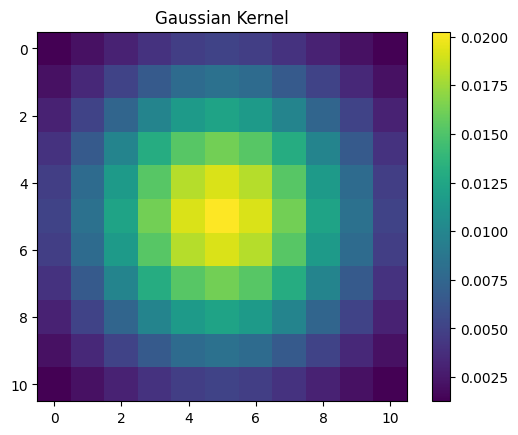

In [ ]:
kernel = gaussian_kernel(kernel_size, sigma)
print(kernel.dtype)  # Should output: float64

plt.imshow(kernel, cmap='viridis')
plt.title('Gaussian Kernel')
plt.colorbar()
plt.show()


In [ ]:
#Apply the custom convolution function using Gaussian kernel
gaussian_filtered = my_convolve2d(gray_np, kernel)

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

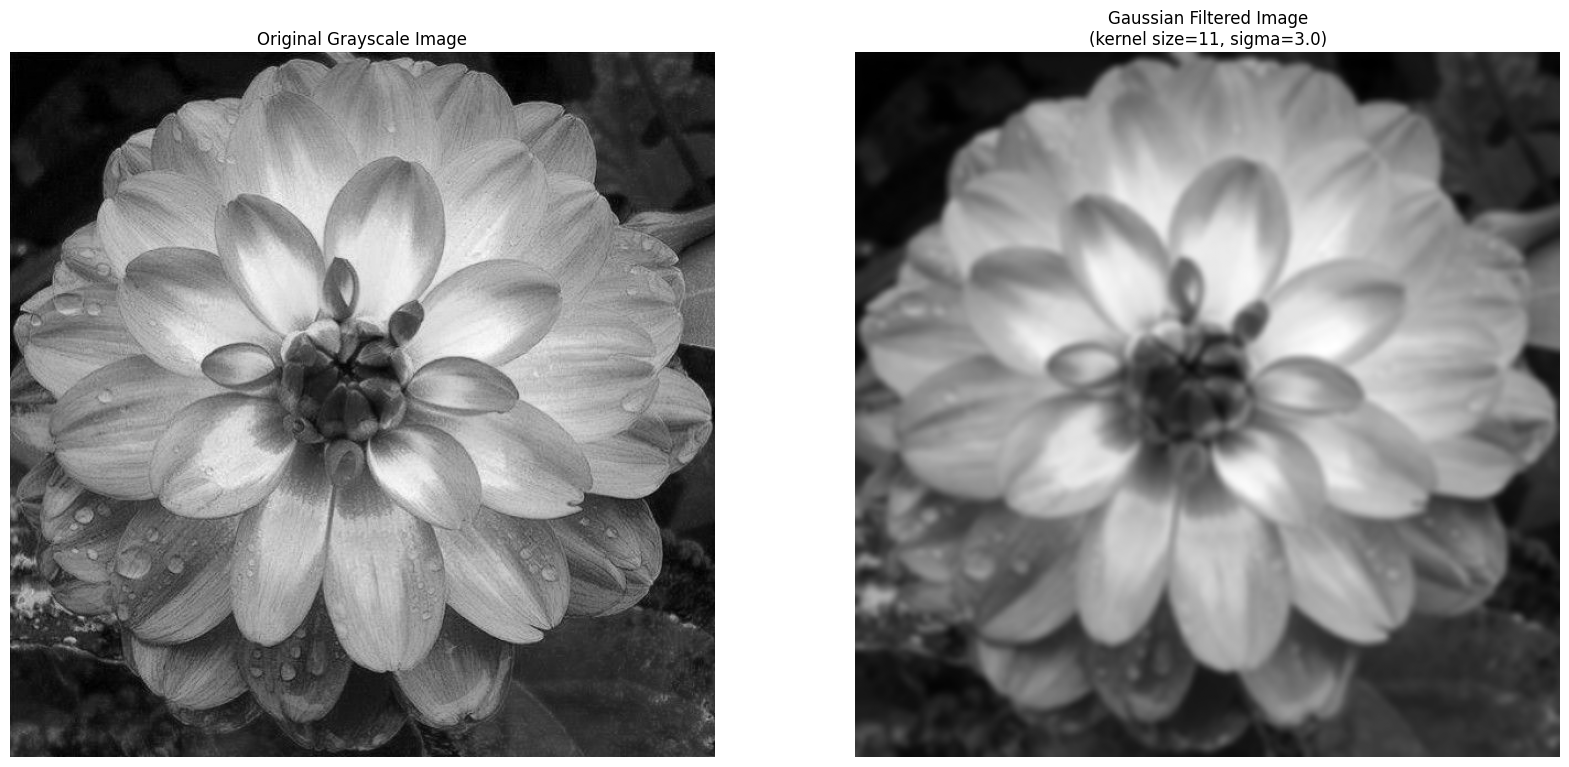

In [ ]:
# Step 4: Display the original grayscale image and the Gaussian filtered image
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(gray_np, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gaussian_filtered, cmap='gray')
plt.title(f'Gaussian Filtered Image\n(kernel size={kernel_size}, sigma={sigma})')
plt.axis('off')

In [ ]:
def harris_detector(gray_np, k=0.04, threshold=0.01, kernel_size=11, sigma=3):
  """
  Perform Harris Corner Detection on  a grayscale image.

  Parameters:
  Gray                 : 2D numpy array representing a grayscale image.
  k                    :
  threshold_ratio      :
  gaussian_kernel_size :Size of the Gaussian kernel used for smoothing
  Sigma                :std for gaussian kernel

  Returns:
  R                    :2D array containing the Harris response at each pixel
  corners              :2D boolean array where True indicates a detected corner.
  corner_coords        :Coordinates of detected corners.
  """

  #Step 1: Compute image gradients using Sobel operator.
  sobel_x = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])
  sobel_y = np.array([[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]])

  Ix = my_convolve2d(gray_np, sobel_x)
  Iy = my_convolve2d(gray_np, sobel_y)

  #Step 2: Compute products of derivatives
  Ixx = Ix**2
  Iyy = Iy**2
  Ixy = Ix*Iy

  #Step 3: Smooth the gradient products using a Gaussian Filter
  gauss = gaussian_kernel(kernel_size, sigma)
  Sxx = my_convolve2d(Ixx, gauss)
  Syy = my_convolve2d(Iyy, gauss)
  Sxy = my_convolve2d(Ixy, gauss)

  #Step 4: Compute the Harris response
  #Compute determinant and trace of the structure tensor
  det_M = Sxx*Syy - Sxy**2
  trace_M = Sxx + Syy
  R = det_M - k*(trace_M**2)

  #Step 5: Threshold the response to identify corners.
  R_threshold = threshold*R.max()
  corners = R > R_threshold
  corner_coords = np.where(corners)

  return R, corners, corner_coords


In [ ]:
#Run the Harris detector on the grayscale image.
R, corners, corner_coords = harris_detector(gray_np, k=0.04, threshold=0.01, kernel_size=11, sigma=3)

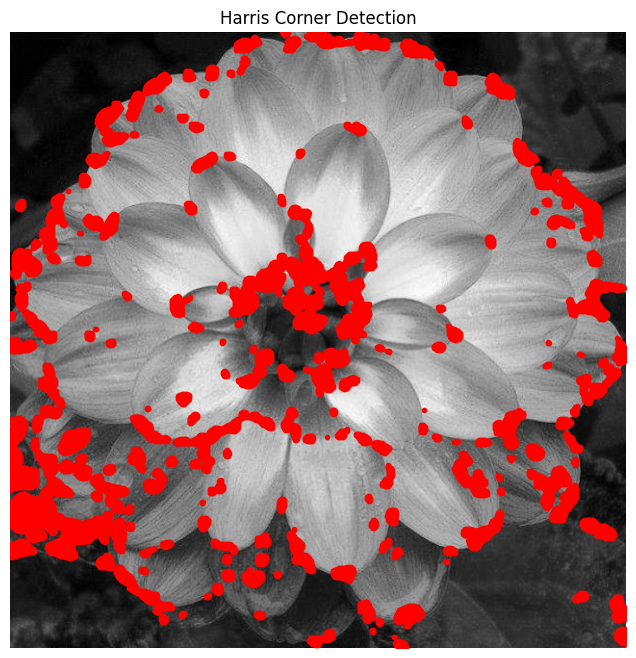

In [ ]:
# Step D: Visualize the results.
plt.figure(figsize=(8, 8))
plt.imshow(gray_np, cmap='gray')
plt.title('Harris Corner Detection')
plt.axis('off')

corner_y, corner_x = np.where(corners)
plt.plot(corner_x, corner_y, 'ro', markersize=3)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def non_max_suppression(R, window_size=3):
    """
    Perform non-maximum suppression on a 2D Harris response map.

    Parameters:
    R           : 2D numpy array of Harris response values.
    window_size : Integer specifying the size of the window to search for local maxima.
                  It must be an odd number. (Default is 3)

    Returns:
    suppressed  : 2D boolean numpy array where True indicates a local maximum.
    """
    # Get the height and width of the Harris response map.
    H, W = R.shape

    # Calculate the amount of padding required
    pad = window_size // 2

    # Pad the Harris response map with -infinity so that border pixels have a well-defined neighborhood
    # Using -np.inf ensures that border pixels are not erroneously suppressed because any real response is higher.
    R_padded = np.pad(R, ((pad, pad), (pad, pad)), mode='constant', constant_values=-np.inf)

    # Initialize an output array to store the local maximum flags (all set to False initially).
    suppressed = np.zeros_like(R, dtype=bool)

    # Iterate over every pixel in the original (unpadded) response map.
    for i in range(H):
        for j in range(W):
            # The current pixel's value in the padded response map is at position (i + pad, j + pad)
            current_value = R_padded[i + pad, j + pad]

            # Extract a window of size (window_size x window_size) around the current pixel.
            window = R_padded[i:i + window_size, j:j + window_size]

            # Check if the current value is equal to the maximum value in this window.
            # If it is, mark this pixel as a local maximum (candidate corner).
            if current_value == np.max(window):
                suppressed[i, j] = True

    return suppressed

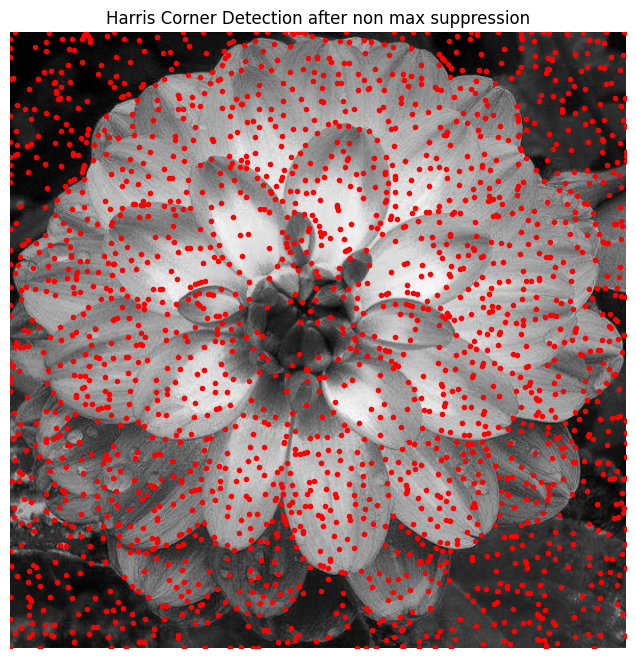

In [ ]:
nms_mask = non_max_suppression(R, window_size=3)
plt.figure(figsize=(8, 8))
plt.imshow(gray_np, cmap='gray')
plt.title('Harris Corner Detection after non max suppression')
nms_y, nms_x = np.where(nms_mask)
plt.plot(nms_x, nms_y, 'ro', markersize=3)
plt.axis('off')
plt.show()